In [609]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBRegressor
%matplotlib inline

#Преобразование данных

In [610]:
#Выгрузим данные
data = pd.read_csv('/content/allBank_balance_101_sector.csv')
data.tail(100)


,report_date,sector_id,bank_group_id,value_rub,value_usd
215464,2019-05-01,43,38,163.269333,0.000000
215465,2019-05-01,46,38,8.810060,0.000000
215466,2019-05-01,42,38,3.555876,0.000000
215467,2019-05-01,40,71,3.269680,0.454437
215468,2019-05-01,12,71,0.364835,0.037540
...,...,...,...,...,...
215559,2019-05-01,53,66,0.345000,0.046932
215560,2019-05-01,54,66,12.070842,4.746029
215561,2019-05-01,44,66,0.000140,0.000000
215562,2019-05-01,46,66,0.000140,0.000000


In [611]:
data['report_date'] = pd.to_datetime(data['report_date'])
data

,report_date,sector_id,bank_group_id,value_rub,value_usd
0,2007-02-01,40,6,9.408740,8.925271
1,2007-02-01,10,6,31.943854,36.274318
2,2007-02-01,41,6,48.045392,20.535636
3,2007-02-01,12,6,4.604419,15.616651
4,2007-02-01,15,6,0.041111,0.000002
...,...,...,...,...,...
215559,2019-05-01,53,66,0.345000,0.046932
215560,2019-05-01,54,66,12.070842,4.746029
215561,2019-05-01,44,66,0.000140,0.000000
215562,2019-05-01,46,66,0.000140,0.000000


In [612]:
sber_dep = data.loc[(data['bank_group_id']==1) & (data['sector_id'].isin([1,2,3,4]))]
sber_dep = sber_dep.drop(['bank_group_id','value_usd'],axis=1)

sber = sber_dep.groupby(sber_dep.report_date).agg('sum')

sber_dep.head(10)

,report_date,sector_id,value_rub
467,2007-02-01,2,27.283416
468,2007-02-01,1,0.920018
469,2007-02-01,3,7.342596
470,2007-02-01,4,47.034125
1402,2007-03-01,2,44.244502
1403,2007-03-01,1,1.580018
1404,2007-03-01,3,7.490046
1405,2007-03-01,4,52.539326
2409,2007-04-01,2,72.162548
2410,2007-04-01,1,0.000018


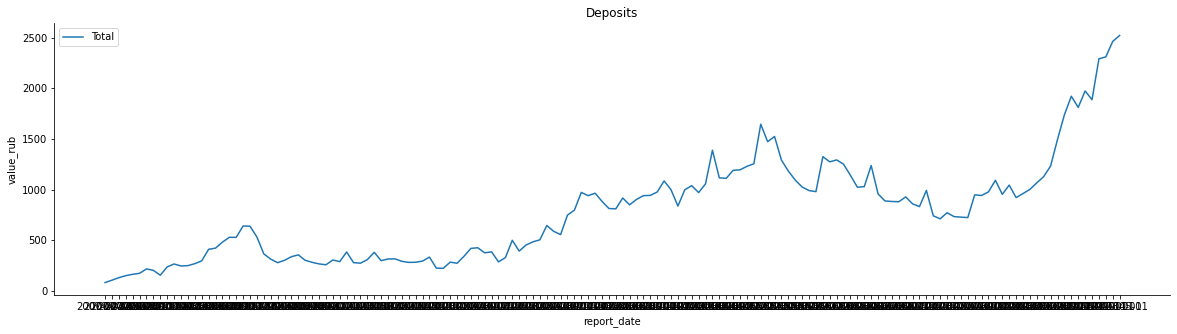

In [613]:
#Визуализируем
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(20,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, label='Total')
    
    #second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    #second.date = pd.to_datetime(second.date, format='%Y')
    #sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "report_date",
           ylabel = "value_rub",
           title = title)
    
    sns.despine()
time_plot(sber_year, 'report_date', 'value_rub','Deposits')

In [614]:
#KPSS test, Dickey–Fuller test на

print(" > Is the data stationary ?")
dftest = kpss(sber_i.value_rub, 'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))    #

print("\n > Is the de-trended data stationary ?")
dftest = adfuller(sber_i.value_rub.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    

 > Is the data stationary ?
Test statistic = 0.065
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216

 > Is the de-trended data stationary ?
Test statistic = 1.040
P-value = 0.995
Critical values :
	1%: -3.4759527332353084 - The data is not stationary with 99% confidence
	5%: -2.881548071241103 - The data is not stationary with 95% confidence
	10%: -2.577438765246763 - The data is not stationary with 90% confidence


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


#Подбор и обучение моделей


In [615]:
#Реализуем RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [616]:
sber_i = sber.drop('sector_id',axis=1)
train, test = sber_i.iloc[:136,:], sber_i.iloc[136:,:]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
sber_i

,value_rub
report_date,
2007-02-01,82.580155
2007-03-01,105.853892
2007-04-01,130.690753
2007-05-01,150.535440
2007-06-01,163.969009
...,...
2019-01-01,1886.625394
2019-02-01,2290.168715
2019-03-01,2309.455969


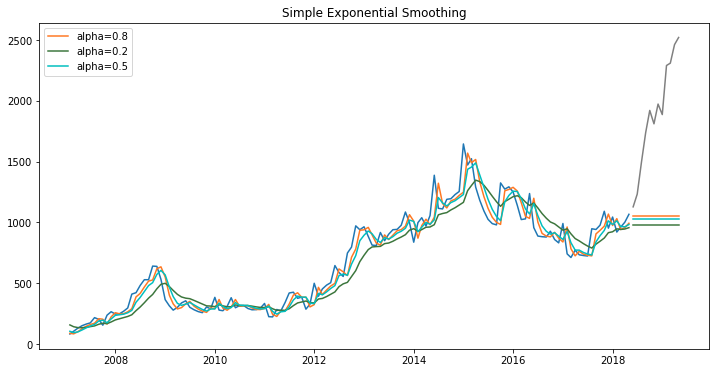

In [617]:
#Простое экспоненциальное сглаживание
model = SimpleExpSmoothing(np.asarray(train['value_rub']))
fit1 = model.fit()
pred1 = fit1.forecast(12)
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(12)
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(12)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend()

results['Simple Exp Smoothing']=min(rmse(pred1,test['value_rub']),rmse(pred2,test['value_rub']),rmse(pred3,test['value_rub']))


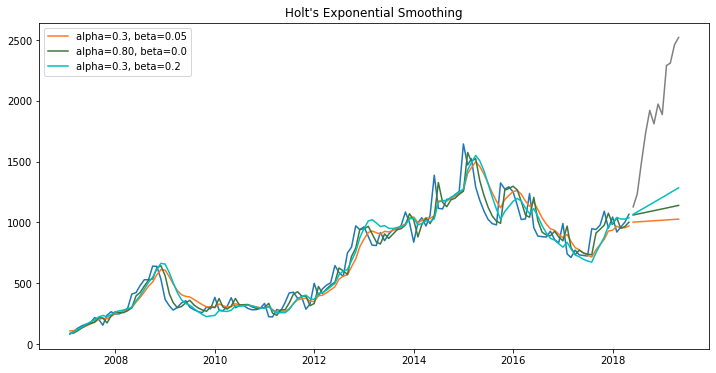

In [618]:
#Модель Хольта
model = Holt(np.asarray(np.asarray(train['value_rub'])))

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(12)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(12)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(12)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend()

results["Holt's Exponential Smoothing"]=min(rmse(pred1,test['value_rub']),rmse(pred2,test['value_rub']),rmse(pred3,test['value_rub']))

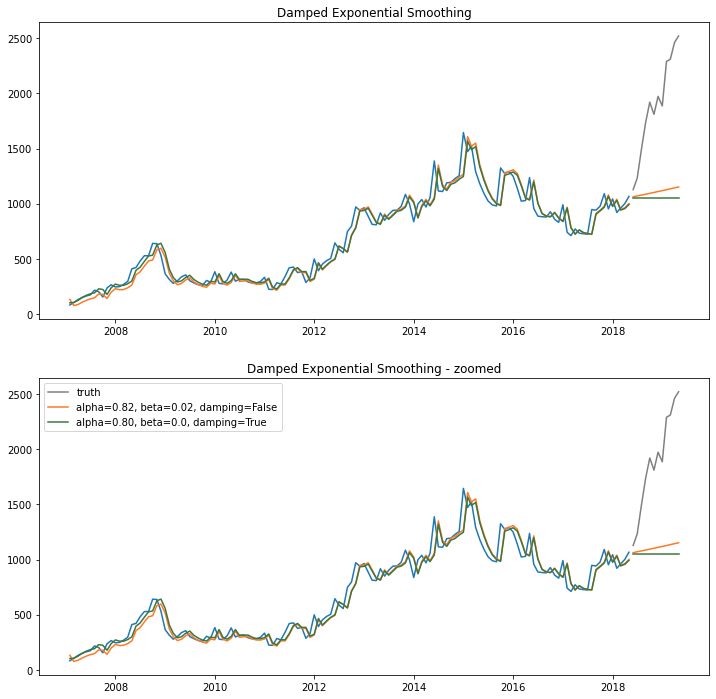

In [619]:
#Модель Хольта-Винтерса
model = ExponentialSmoothing(np.asarray(train['value_rub']), trend='mul', seasonal=None)
model2 = ExponentialSmoothing(np.asarray(train['value_rub']), trend='mul', seasonal=None, damped=True)


fit1 = model.fit()
fit2 = model2.fit()
pred1 = fit1.forecast(12)
pred2 = fit2.forecast(12)

fig, ax = plt.subplots(2, figsize=(12, 12))
ax[0].plot(train.index, train.values)
ax[0].plot(test.index, test.values, color="gray", label="truth")
ax[1].plot(train.index, train.values)
ax[1].plot(test.index, test.values, color="gray", label="truth")
for p, f, c in zip((pred1, pred2),(fit1, fit2),('#ff7823','#3c763d')):
    ax[0].plot(train.index, f.fittedvalues, color=c)
    ax[1].plot(train.index, f.fittedvalues, color=c)
    ax[0].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False), color=c)
    ax[1].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False), color=c)
ax[0].set_title("Damped Exponential Smoothing")
ax[1].set_title("Damped Exponential Smoothing - zoomed")
plt.legend()

results["Holt-Winters' Exponential Smoothing"]=min(rmse(pred1,test['value_rub']),rmse(pred2,test['value_rub']))

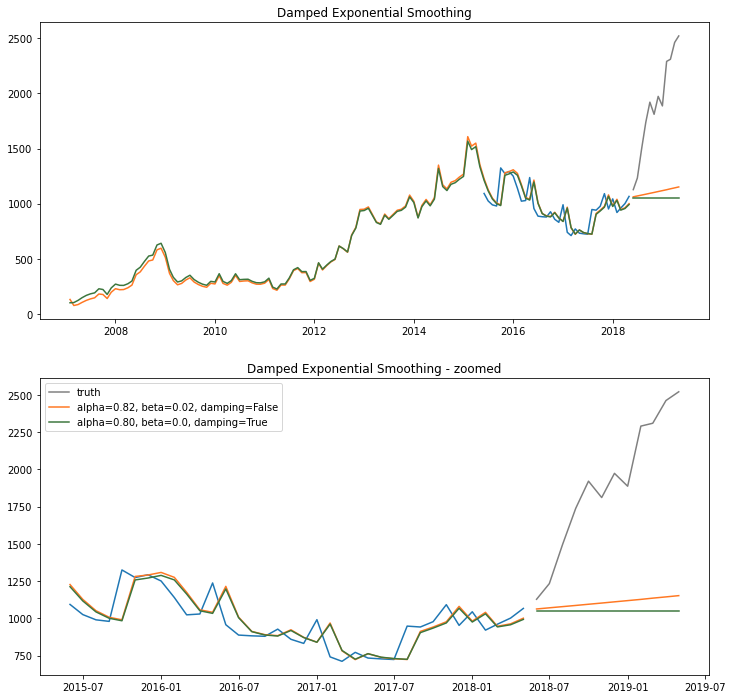

In [620]:
#Модель Хольта-Винтерса
model = ExponentialSmoothing(np.asarray(train['value_rub']), trend='mul', seasonal=None)
model2 = ExponentialSmoothing(np.asarray(train['value_rub']), trend='mul', seasonal=None, damped=True)


fit1 = model.fit()
fit2 = model2.fit()
pred1 = fit1.forecast(12)
pred2 = fit2.forecast(12)

fig, ax = plt.subplots(2, figsize=(12, 12))
ax[0].plot(train.index[100:], train.values[100:])
ax[0].plot(test.index, test.values, color="gray", label="truth")
ax[1].plot(train.index[100:], train.values[100:])
ax[1].plot(test.index, test.values, color="gray", label="truth")
for p, f, c in zip((pred1, pred2),(fit1, fit2),('#ff7823','#3c763d')):
    ax[0].plot(train.index, f.fittedvalues, color=c)
    ax[1].plot(train.index[100:], f.fittedvalues[100:], color=c)
    ax[0].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False), color=c)
    ax[1].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False), color=c)
ax[0].set_title("Damped Exponential Smoothing")
ax[1].set_title("Damped Exponential Smoothing - zoomed")
plt.legend()

results["Holt-Winters' Exponential Smoothing"]=min(rmse(pred1,test['value_rub']),rmse(pred2,test['value_rub']))

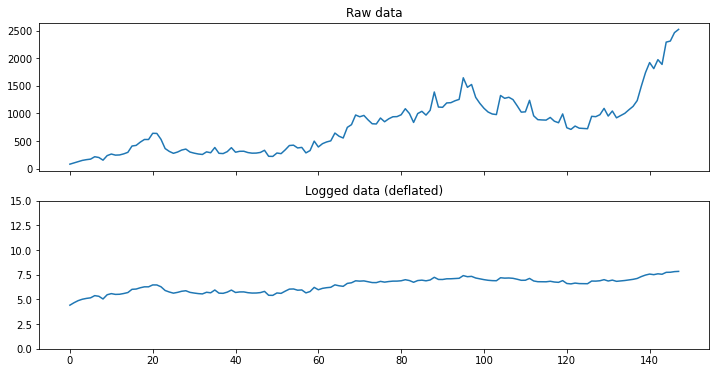

In [621]:
#Приведем данные к стационарному виду
fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))
ax[0].plot(sber_i.value_rub.values);
ax[0].set_title("Raw data");
ax[1].plot(np.log(sber_i.value_rub.values));
ax[1].set_title("Logged data (deflated)");
ax[1].set_ylim(0, 15);



In [622]:
dftest = kpss(np.log(sber_i.value_rub), 'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))  

Test statistic = 0.092
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-

                              ARMA Model Results                              
Dep. Variable:              value_rub   No. Observations:                  148
Model:                     ARMA(0, 0)   Log Likelihood                -160.799
Method:                           css   S.D. of innovations              0.717
Date:                Tue, 28 Jul 2020   AIC                            325.598
Time:                        02:35:39   BIC                            331.592
Sample:                    02-01-2007   HQIC                           328.033
                         - 05-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4289      0.059    109.057      0.000       6.313       6.544
                             ARIMA Model Results                              
Dep. Variable:            D.value_rub   No. Observat

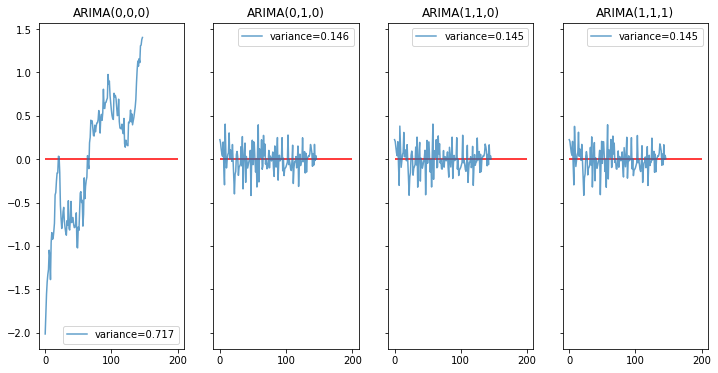

In [623]:
#Используем ARIMA с различными параметрами (p,d,q)
model = ARIMA(np.log(sber_i.value_rub).dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(sber_i.value_rub).dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

model = ARIMA(np.log(sber_i.value_rub).dropna(), (1, 1, 0))
res_110 = model.fit()
print(res_110.summary())

model = ARIMA(np.log(sber_i.value_rub).dropna(), (1, 1, 1))
res_111 = model.fit()
print(res_111.summary())

fig, ax = plt.subplots(1, 4, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)))
ax[0].hlines(0, xmin=0, xmax=200, color='r')
ax[0].set_title("ARIMA(0,0,0)")
ax[0].legend()

ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)))
ax[1].hlines(0, xmin=0, xmax=200, color='r')
ax[1].set_title("ARIMA(0,1,0)")
ax[1].legend()

ax[2].plot(res_110.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_110.resid.values)))
ax[2].hlines(0, xmin=0, xmax=200, color='r')
ax[2].set_title("ARIMA(1,1,0)")
ax[2].legend()

ax[3].plot(res_111.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_111.resid.values)))
ax[3].hlines(0, xmin=0, xmax=200, color='r')
ax[3].set_title("ARIMA(1,1,1)")
ax[3].legend()

results["ARIMA"]=min(rmse(np.exp(res_110.predict('2018-06-01', '2019-06-01')),sber_i.value_rub[-12:]),\
                     rmse(np.exp(res_110.predict('2018-06-01', '2019-06-01')),sber_i.value_rub[-12:]),\
                     rmse(np.exp(res_110.predict('2018-06-01', '2019-06-01')),sber_i.value_rub[-12:]))

In [624]:
#Реализуем функцию для создания датафрейма с данными с лагом
def create_lag_features(y,col):
   
    scaler = StandardScaler()
    features = pd.DataFrame()
    
    partial = pd.Series(data=pacf(y, nlags=12))
    lags = list(partial[np.abs(partial) >= 0.2].index)
    
    df = pd.DataFrame()
    
    # avoid to insert the time series itself
    lags.remove(0)
    
    for l in lags:
        df[f"lag_{l}"+'_'+col] = y.shift(l)
    
    features = pd.DataFrame(df[df.columns],
                            columns=df.columns)
    features.index = y.index
    
    return features

In [625]:
features = create_lag_features(sber_i['value_rub'].diff().dropna(),'value_rub')
lag_df=sber_i.diff().dropna()
lag_df = lag_df.join(features).dropna()
lag_df

,value_rub,lag_7_value_rub
report_date,,
2007-10-01,-48.309256,23.273737
2007-11-01,82.469881,24.836861
2007-12-01,28.601092,19.844687
2008-01-01,-19.852442,13.433569
2008-02-01,3.426117,9.804340
...,...,...
2019-01-01,-86.559248,61.217222
2019-02-01,403.543321,105.185523
2019-03-01,19.287254,261.768324


In [626]:
train_x, train_y = lag_df.drop('value_rub',axis=1)[:-12],lag_df['value_rub'][:-12]
test_x, test_y = lag_df.drop('value_rub',axis=1)[-12:],lag_df['value_rub'][-12:]
                                                                     

In [627]:
#Обучим модель градиентного бустинга
model = XGBRegressor(
    max_depth=8,
    n_estimators=500, 
    colsample_bytree=1, 
    subsample=1, 
    eta=0.5,    
    seed=42)

model.fit(train_x, train_y)
pred_1 = model.predict(test_x)
results['XGBOOST']=rmse(pred_1,sber_i['value_rub'][-12:])

[02:35:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#Прогнозирование

In [628]:
for key,value in results.items():
  print(key, ':', value)

Simple Exp Smoothing : 949.8628318859359
Holt's Exponential Smoothing : 810.6377160055657
Holt-Winters' Exponential Smoothing : 889.1205856563328
ARIMA : 1945.4071772120044
XGBOOST : 1955.0084871383647


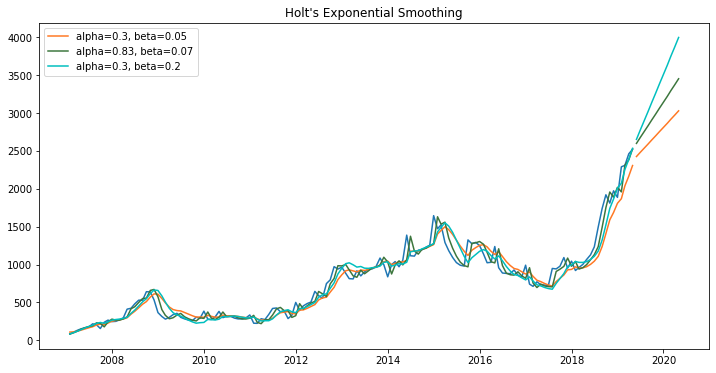

In [629]:
#Создадим прогноз модели с наименьшим RMSE
model = Holt(np.asarray(np.asarray(sber_i['value_rub'])))


fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(12)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(12)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(12)

pred_index = pd.DatetimeIndex(['2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
                              '2019-10-01', '2019-11-01', '2019-12-01','2020-01-01',
                               '2020-02-01','2020-03-01','2020-04-01','2020-05-01'])
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(sber_i.index, sber_i.values)
#ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(sber_i.index, f.fittedvalues, color=c)
    ax.plot(pred_index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend()